In [1]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

!unzip rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [3]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
data_path = "/content/Rice_Image_Dataset"

images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [5]:
data.head()

,image,label
0,/content/Rice_Image_Dataset/Basmati/basmati (2...,Basmati
1,/content/Rice_Image_Dataset/Basmati/basmati (1...,Basmati
2,/content/Rice_Image_Dataset/Basmati/basmati (5...,Basmati
3,/content/Rice_Image_Dataset/Basmati/basmati (5...,Basmati
4,/content/Rice_Image_Dataset/Basmati/basmati (6...,Basmati


In [6]:
data.shape

(75000, 2)

In [7]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (60000, 2)
Validation set shape: (7500, 2)
Test set shape: (7500, 2)


In [8]:
batch_size = 32
img_size = (50, 50)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


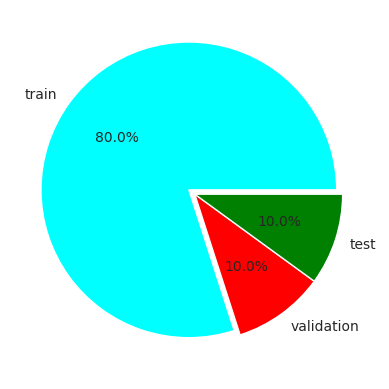

<Figure size 640x480 with 0 Axes>

In [9]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()
plt.savefig('dataset_pie.png')

In [10]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


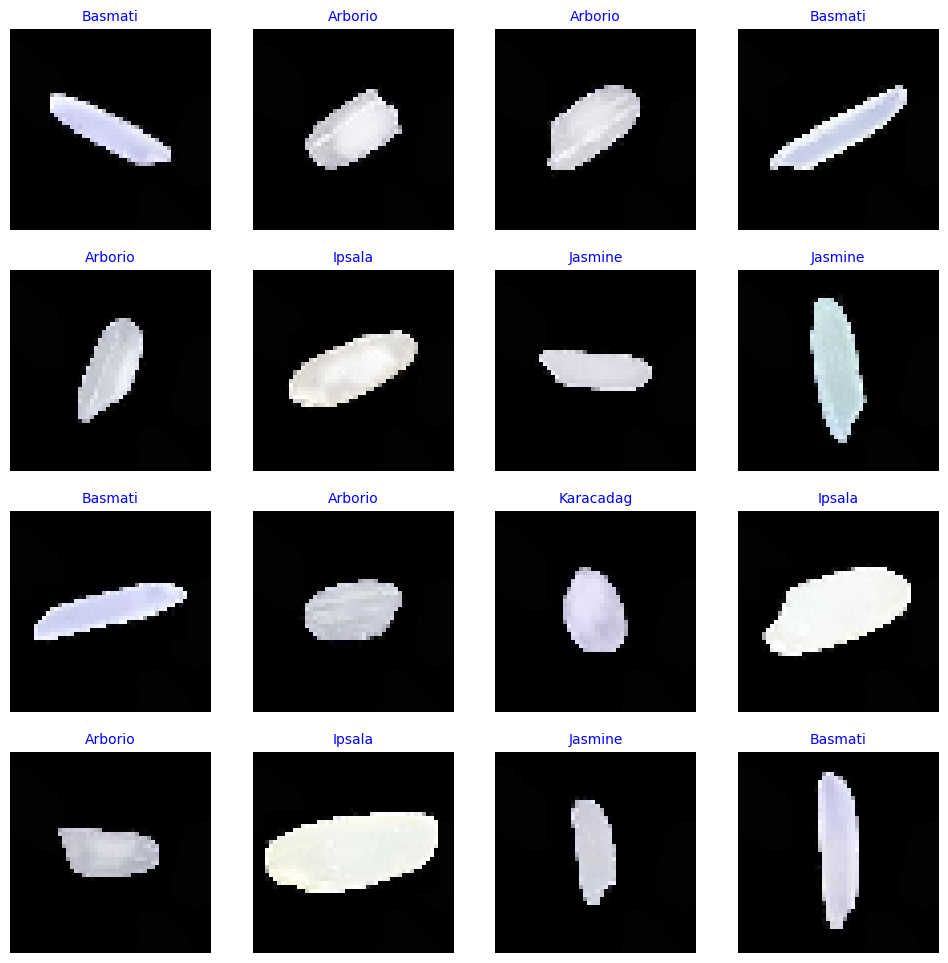

In [11]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

CNN Model

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
input_shape = (50, 50, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 128)               9

Callback and Model Compile

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [15]:
import time

start = time.time()

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

history = model.fit(x= train_gen, epochs= 5, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False, callbacks=[callbacks])
end = time.time()
elapsed = end - start
print("Total Time:", elapsed)

Epoch 1/5
1875/1875 [==============================] - 60s 30ms/step - loss: 0.5538 - accuracy: 0.9542 - val_loss: 0.0761 - val_accuracy: 0.9707
Epoch 2/5
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0630 - accuracy: 0.9788 - val_loss: 0.0588 - val_accuracy: 0.9817
Epoch 3/5
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0409 - accuracy: 0.9862 - val_loss: 0.0376 - val_accuracy: 0.9883
Epoch 4/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0305 - accuracy: 0.9897 - val_loss: 0.0378 - val_accuracy: 0.9881
Epoch 5/5
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0226 - accuracy: 0.9925 - val_loss: 0.0300 - val_accuracy: 0.9895
Total Time: 346.90289998054504


Accuracy and Lose Curve

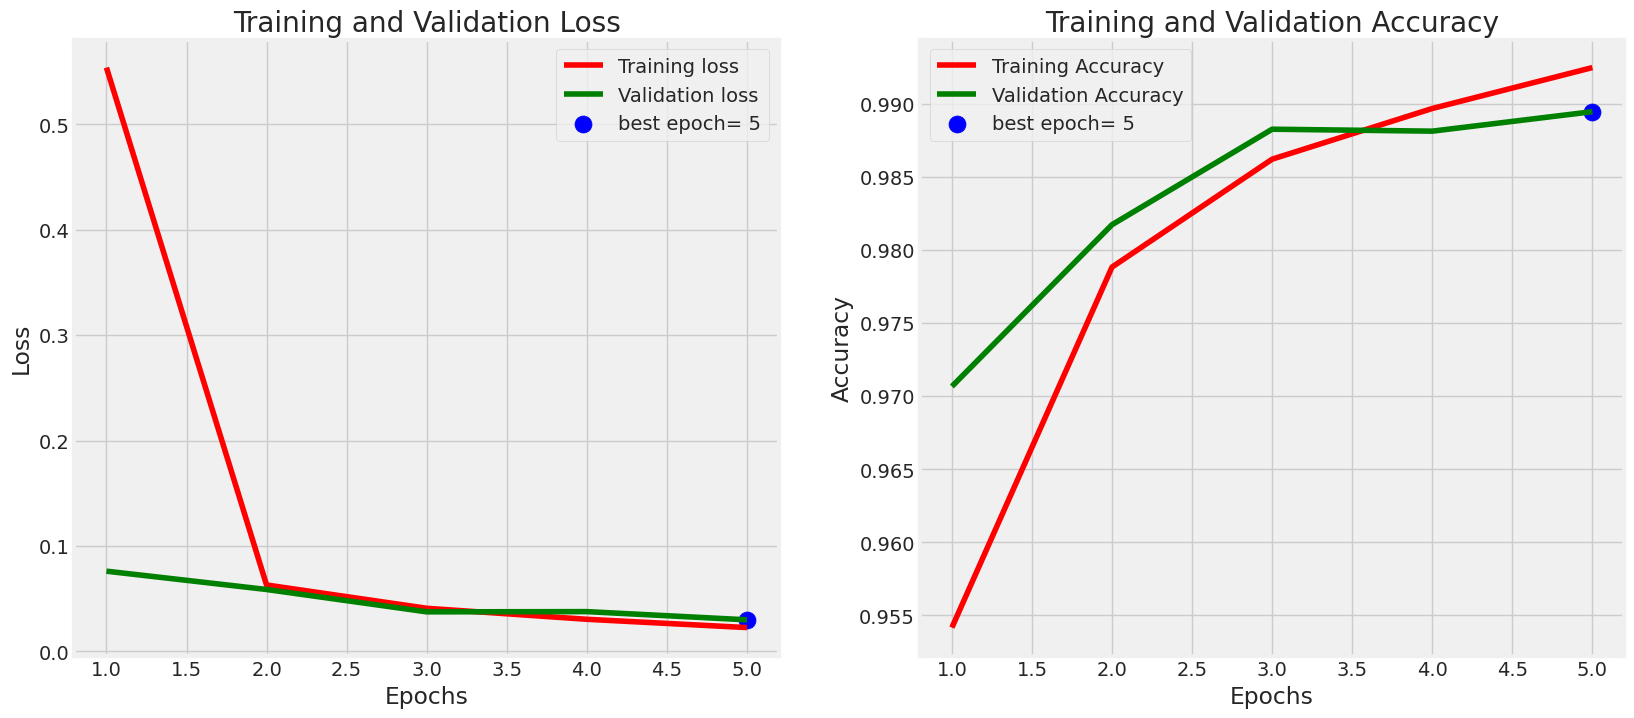

In [16]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [17]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

235/235 [==============================] - 4s 19ms/step - loss: 0.0323 - accuracy: 0.9916
Accuracy score: 0.991599977016449


In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

100/100 [==============================] - 3s 25ms/step - loss: 0.0310 - accuracy: 0.9881
Train Loss:  0.012230957858264446
Train Accuracy:  0.9962499737739563
--------------------
Valid Loss:  0.039334774017333984
Valid Accuracy:  0.9903125166893005
--------------------
Test Loss:  0.030965711921453476
Test Accuracy:  0.9881250262260437


In [19]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

235/235 [==============================] - 4s 18ms/step


In [20]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

     Arborio       0.99      0.98      0.98      1500
     Basmati       0.99      0.99      0.99      1500
      Ipsala       1.00      1.00      1.00      1500
     Jasmine       0.99      0.99      0.99      1500
   Karacadag       0.98      0.99      0.99      1500

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500



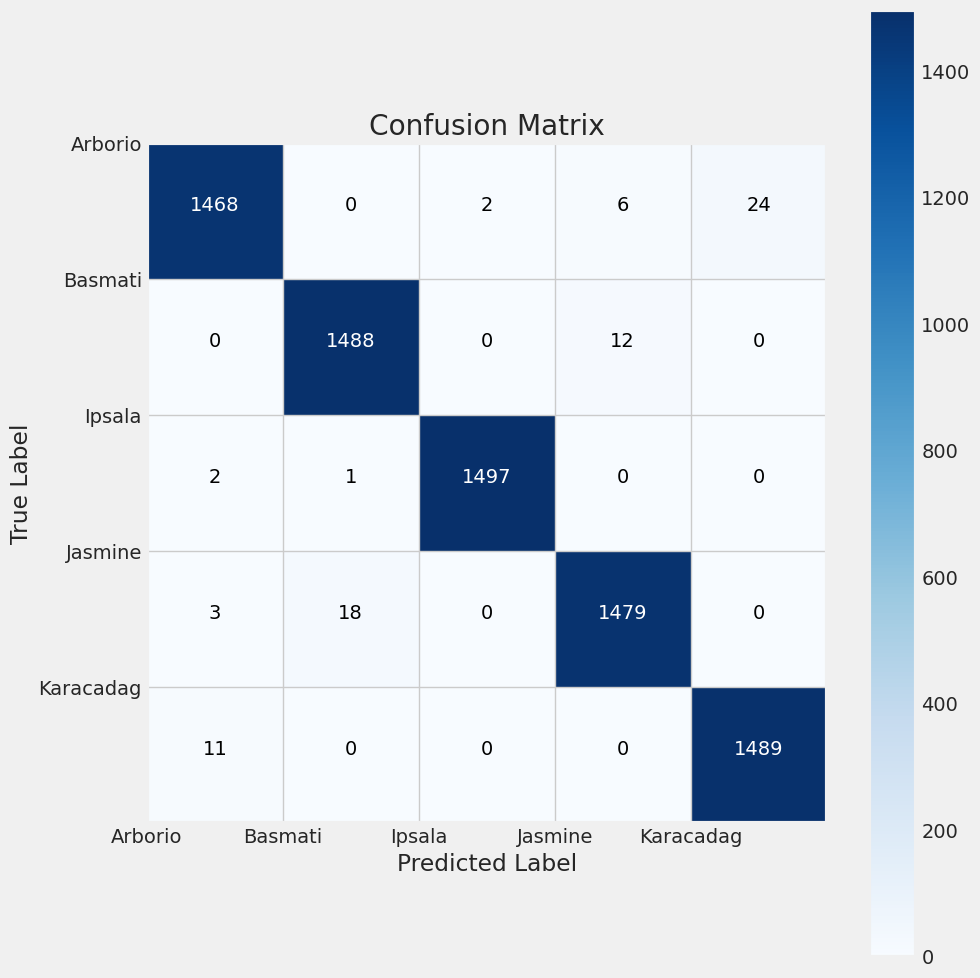

In [21]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)
plt.yticks(tick_marks - 0.5, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
model.save('Model.h5')

235/235 [==============================] - 4s 18ms/step


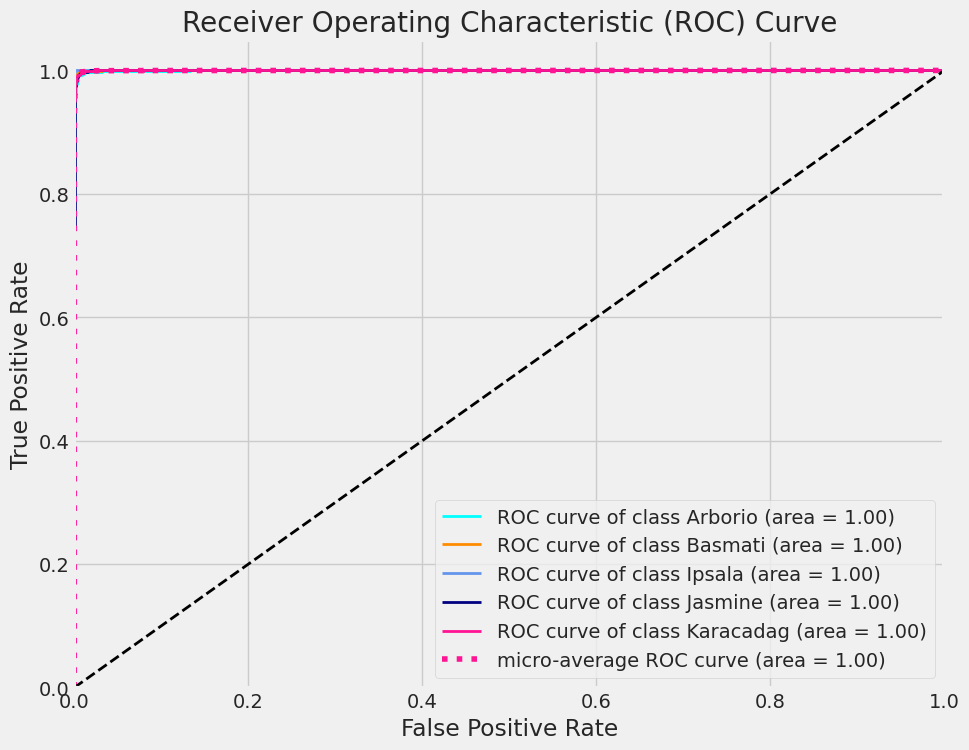

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class Arborio: 1.00
AUC for class Basmati: 1.00
AUC for class Ipsala: 1.00
AUC for class Jasmine: 1.00
AUC for class Karacadag: 1.00
Micro-average AUC: 1.00
Macro-average AUC: 1.00


ResNet50 Model

In [25]:
from keras.applications import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
resnet_base.trainable = False

inputs = Input(shape=(50, 50, 3))

x = resnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)
resnet_model = Model(inputs, outputs)

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

resnet_model.fit(train_gen, epochs=3, validation_data=valid_gen)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/3
1875/1875 [==============================] - 60s 29ms/step - loss: 0.1894 - accuracy: 0.9332 - val_loss: 0.0656 - val_accuracy: 0.9767
Epoch 2/3
1875/1875 [==============================] - 60s 32ms/step - loss: 0.1105 - accuracy: 0.9617 - val_loss: 0.0547 - val_accuracy: 0.9820
Epoch 3/3
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0928 - accuracy: 0.9683 - val_loss: 0.0438 - val_accuracy: 0.9863


In [26]:
test_loss, test_acc = resnet_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.9855999946594238   loss:  0.04715454950928688


83683744/83683744 [==============================] - 1s 0us/step
Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Epoch 1/5
1875/1875 [==============================] - 67s 33ms/step - loss: 0.7323 - accuracy: 0.6962 - val_loss: 0.2109 - val_accuracy: 0.9372
Epoch 2/5
1875/1875 [==============================] - 57s 31ms/step - loss: 0.4711 - accuracy: 0.7822 - val_loss: 0.2263 - val_accuracy: 0.9279
Epoch 3/5
1875/1875 [==============================] - 63s 34ms/step - loss: 0.4260 - accuracy: 0.8043 - val_loss: 0.1431 - val_accuracy: 0.9597
Epoch 4/5
1875/1875 [==============================] - 57s 30ms/step - loss: 0.3868 - accuracy: 0.8458 - val_loss: 0.1223 - val_accuracy: 0.9672
Epoch 5/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.3802 - accuracy: 0.8440 - val_loss: 0.1298 - val_accuracy: 0.9667

Xception Model - accuracy

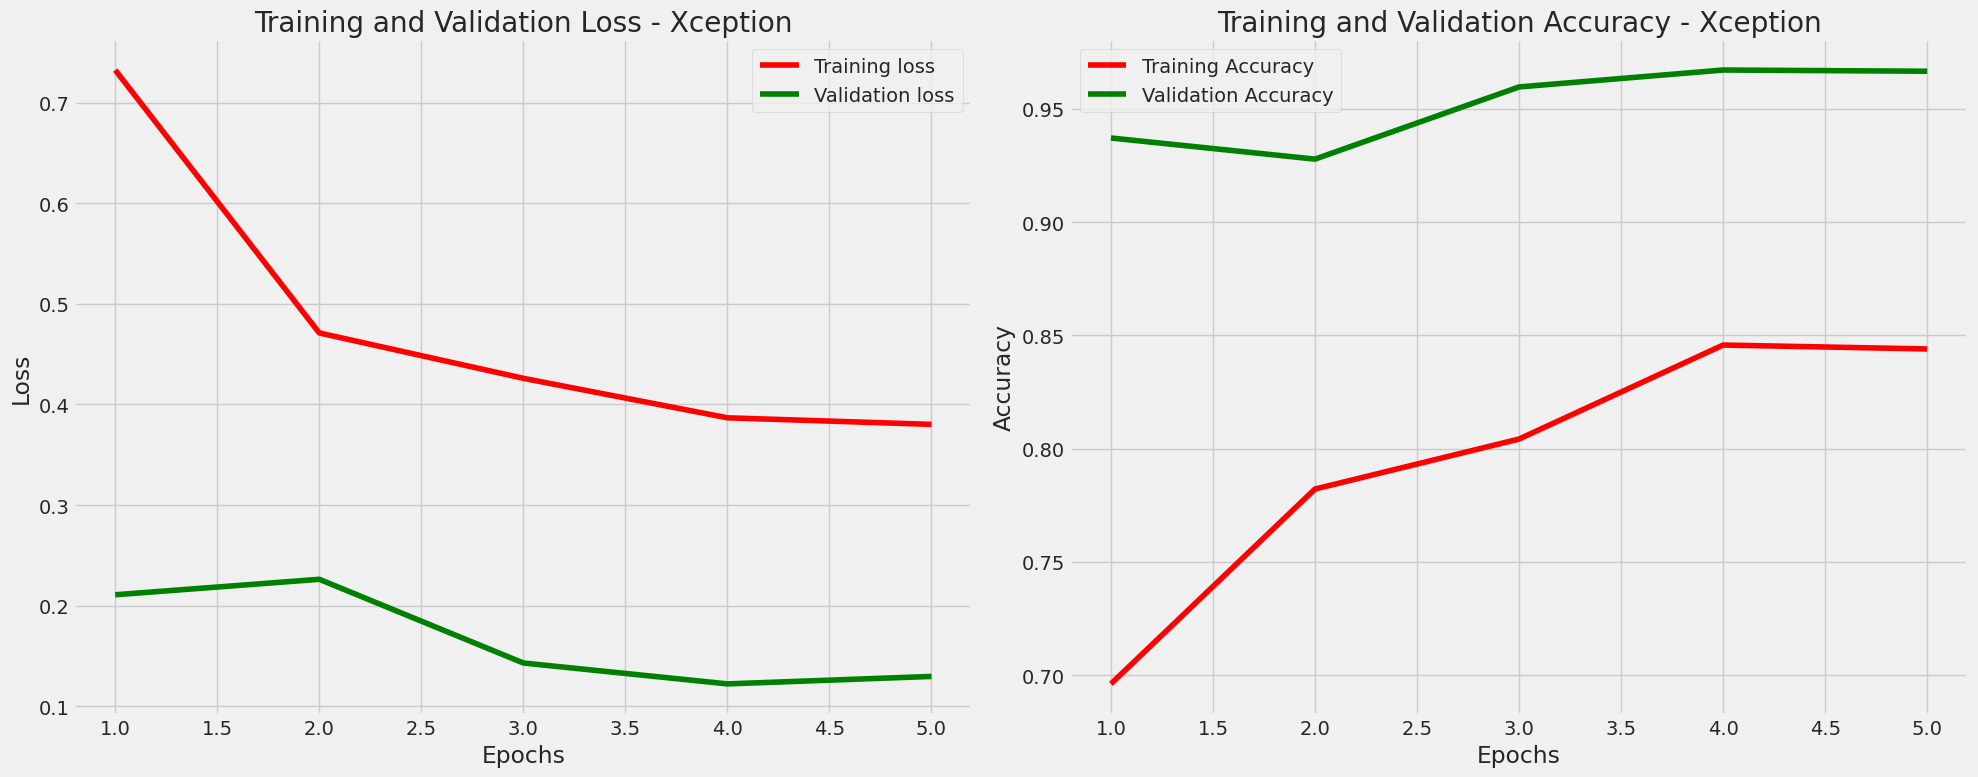

235/235 [==============================] - 8s 29ms/step


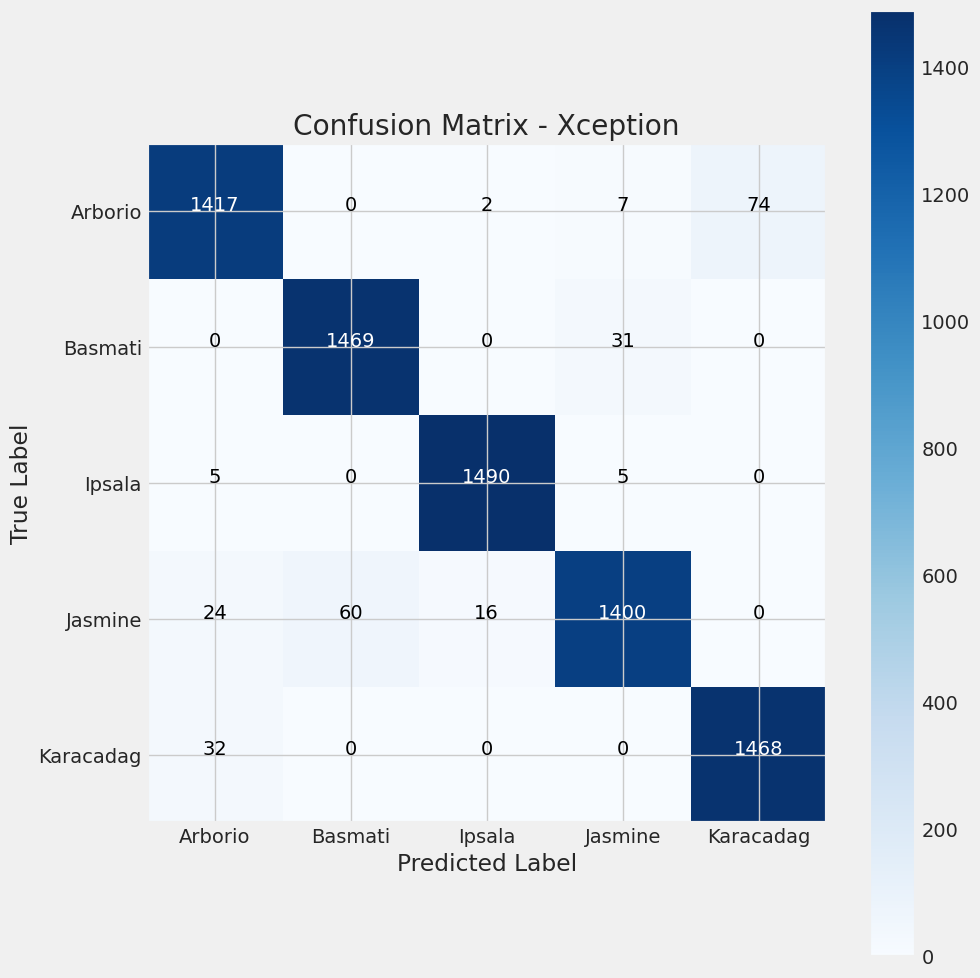

235/235 [==============================] - 6s 25ms/step


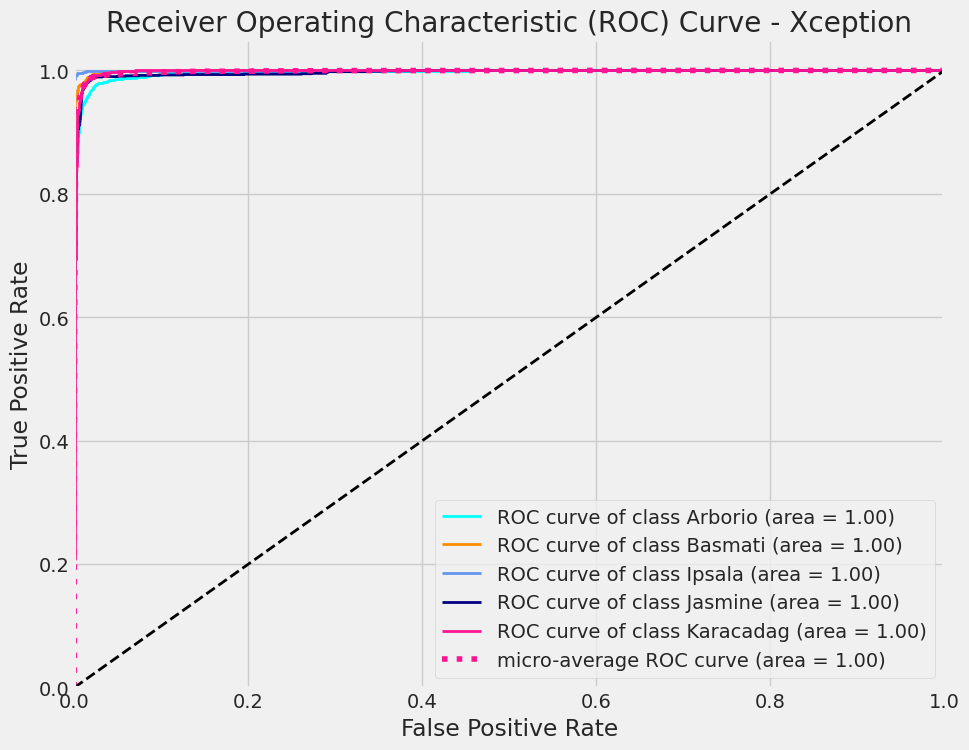

AUC for class Arborio: 1.00
AUC for class Basmati: 1.00
AUC for class Ipsala: 1.00
AUC for class Jasmine: 1.00
AUC for class Karacadag: 1.00
Micro-average AUC: 1.00
Macro-average AUC: 1.00


In [29]:
from keras.applications import Xception
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Updated image size
img_size = (71, 71)
input_shape = (71, 71, 3)

# Load the Xception model
xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
xception_base.trainable = False  # Freeze the base model

# Add custom top layers
inputs = Input(shape=input_shape)
x = xception_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

# Create the model
xception_model = Model(inputs, outputs)

# Compile the model
xception_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Updated data generators with new target size
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Train the model
xception_history = xception_model.fit(train_gen, epochs=5, validation_data=valid_gen)

# Evaluate the model
xception_test_loss, xception_test_acc = xception_model.evaluate(test_gen, verbose=0)
print('\nXception Model - accuracy:', xception_test_acc, '  loss:', xception_test_loss)

# Plot accuracy and loss curves
tr_acc = xception_history.history['accuracy']
tr_loss = xception_history.history['loss']
val_acc = xception_history.history['val_accuracy']
val_loss = xception_history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation Loss - Xception')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - Xception')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
xception_preds = xception_model.predict(test_gen)
xception_y_pred = np.argmax(xception_preds, axis=1)
xception_cm = confusion_matrix(test_gen.classes, xception_y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(xception_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Xception')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = xception_cm.max() / 2.
for i, j in itertools.product(range(xception_cm.shape[0]), range(xception_cm.shape[1])):
    plt.text(j, i, xception_cm[i, j], horizontalalignment='center', color='white' if xception_cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC curve and AUC
n_classes = len(classes)
xception_y_true = label_binarize(test_gen.classes, classes=range(n_classes))
xception_y_pred_probs = xception_model.predict(test_gen)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(xception_y_true[:, i], xception_y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(xception_y_true.ravel(), xception_y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Xception')
plt.legend(loc="lower right")
plt.show()

# AUC Scores
auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(xception_y_true[:, i], xception_y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(xception_y_true, xception_y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(xception_y_true, xception_y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 63s 32ms/step - loss: 0.2598 - accuracy: 0.9455 - val_loss: 0.0531 - val_accuracy: 0.9832
Epoch 2/5
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0798 - accuracy: 0.9739 - val_loss: 0.0466 - val_accuracy: 0.9856
Epoch 3/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0661 - accuracy: 0.9786 - val_loss: 0.0494 - val_accuracy: 0.9843
Epoch 4/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0615 - accuracy: 0.9801 - val_loss: 0.0560 - val_accuracy: 0.9849
Epoch 5/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0600 - accuracy: 0.9815 - val_loss: 0.0495 - val_accuracy: 0.9859

VGG16 Model - accuracy: 0.9857333302497864   loss: 0.05076829716563225


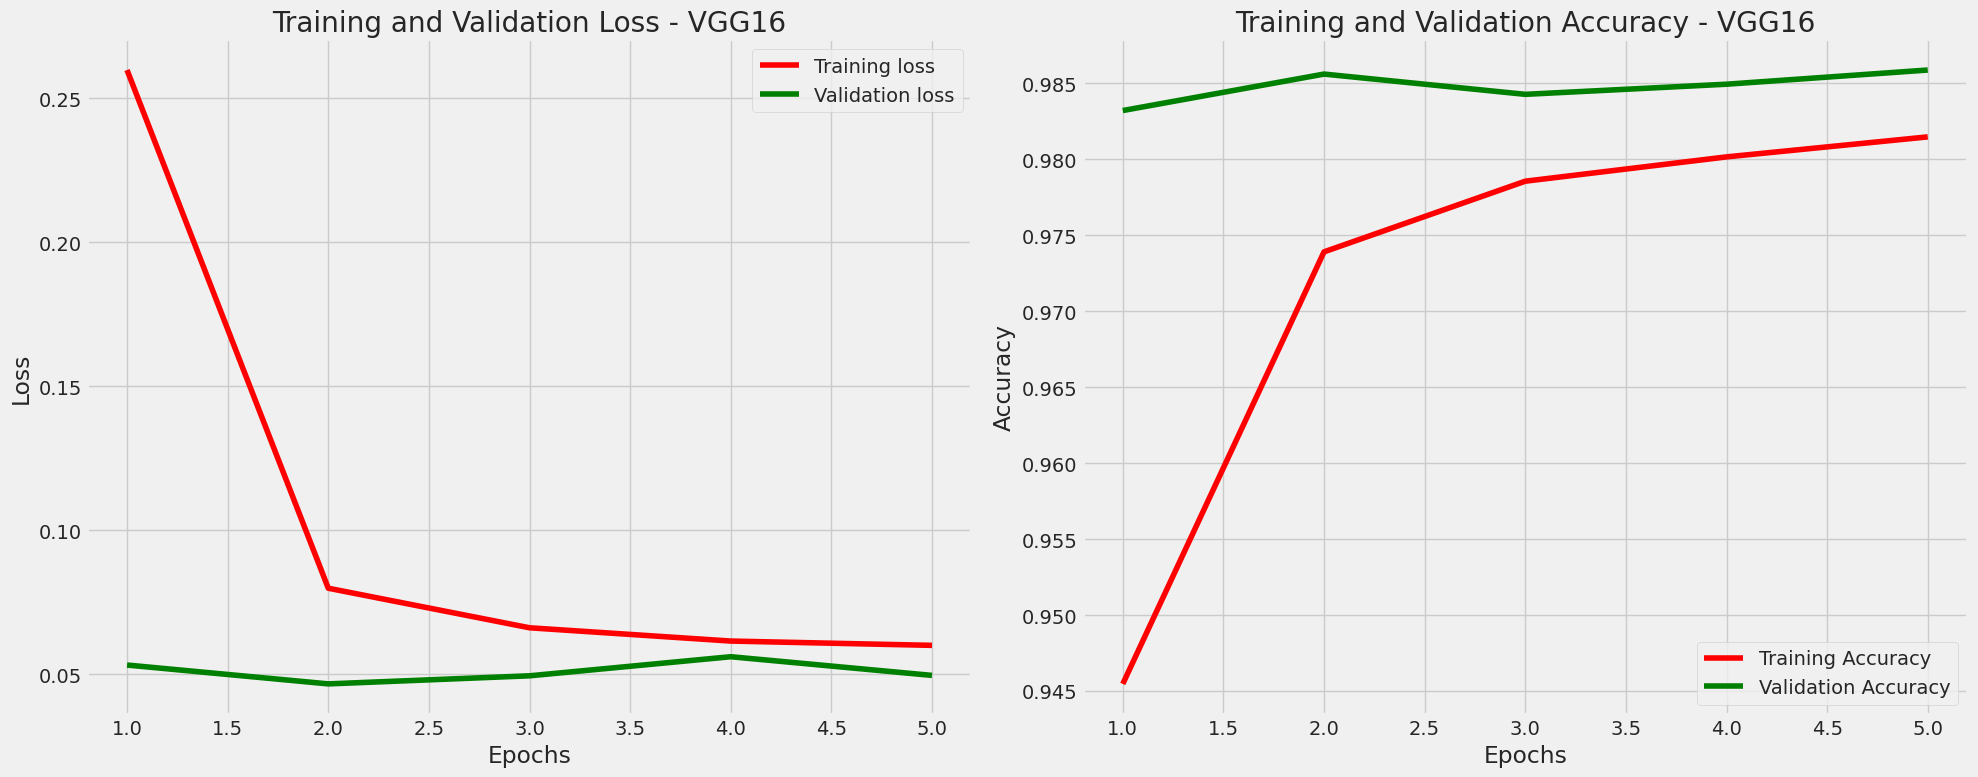

235/235 [==============================] - 6s 25ms/step


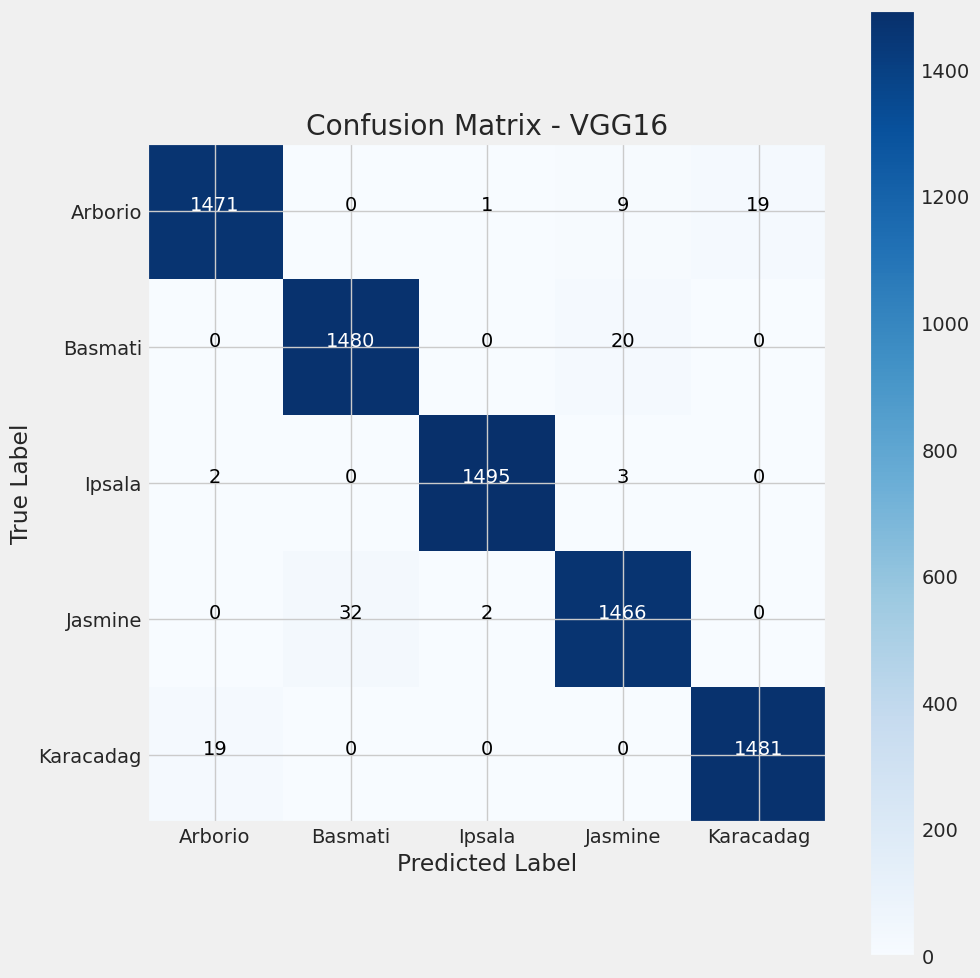

235/235 [==============================] - 5s 23ms/step


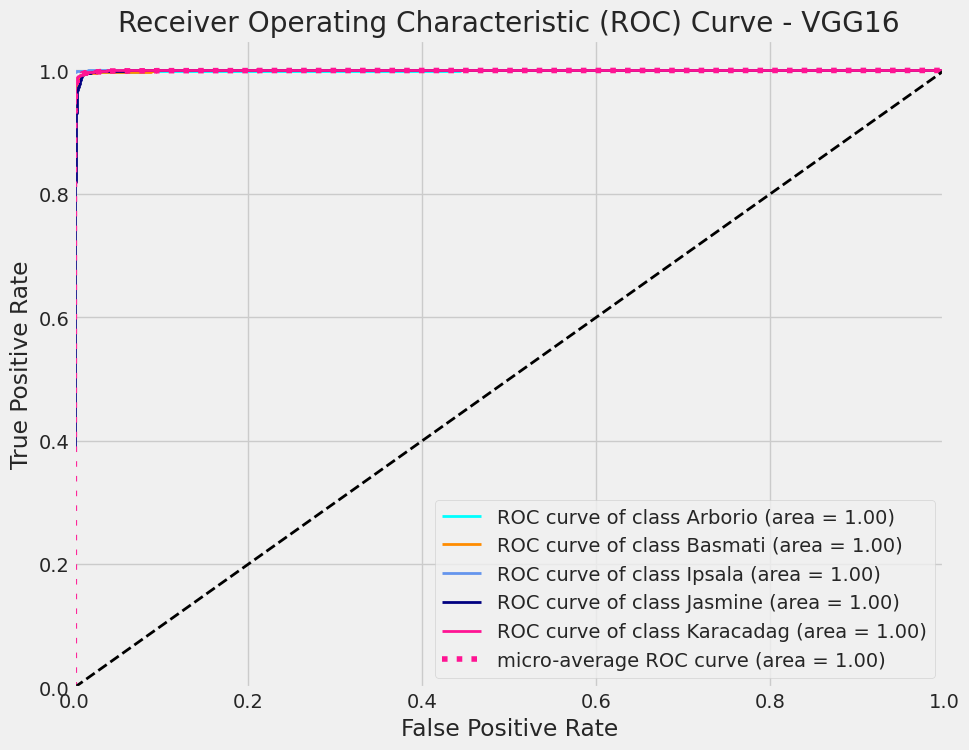

AUC for class Arborio: 1.00
AUC for class Basmati: 1.00
AUC for class Ipsala: 1.00
AUC for class Jasmine: 1.00
AUC for class Karacadag: 1.00
Micro-average AUC: 1.00
Macro-average AUC: 1.00


In [31]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

# Load the VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_base.trainable = False  # Freeze the base model

# Add custom top layers
inputs = Input(shape=input_shape)
x = vgg16_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

# Create the model
vgg16_model = Model(inputs, outputs)

# Compile the model
vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
vgg16_history = vgg16_model.fit(train_gen, epochs=5, validation_data=valid_gen)

# Evaluate the model
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(test_gen, verbose=0)
print('\nVGG16 Model - accuracy:', vgg16_test_acc, '  loss:', vgg16_test_loss)

# Plot accuracy and loss curves
tr_acc = vgg16_history.history['accuracy']
tr_loss = vgg16_history.history['loss']
val_acc = vgg16_history.history['val_accuracy']
val_loss = vgg16_history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation Loss - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
vgg16_preds = vgg16_model.predict(test_gen)
vgg16_y_pred = np.argmax(vgg16_preds, axis=1)
vgg16_cm = confusion_matrix(test_gen.classes, vgg16_y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(vgg16_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - VGG16')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = vgg16_cm.max() / 2.
for i, j in itertools.product(range(vgg16_cm.shape[0]), range(vgg16_cm.shape[1])):
    plt.text(j, i, vgg16_cm[i, j], horizontalalignment='center', color='white' if vgg16_cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC curve and AUC
n_classes = len(classes)
vgg16_y_true = label_binarize(test_gen.classes, classes=range(n_classes))
vgg16_y_pred_probs = vgg16_model.predict(test_gen)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(vgg16_y_true[:, i], vgg16_y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(vgg16_y_true.ravel(), vgg16_y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - VGG16')
plt.legend(loc="lower right")
plt.show()

# AUC Scores
auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(vgg16_y_true[:, i], vgg16_y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(vgg16_y_true, vgg16_y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(vgg16_y_true, vgg16_y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")